In [2]:
import toml
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from rl_analysis.behavior.moseq import syll_onset
from rl_analysis.io.df import dlight_exclude_toml, NONSYLL_COLS, load_dlight_features
from rl_analysis.photometry.windowing import window_trials_as_df
from rl_analysis.plotting import save_factory, setup_plotting_env, clean_ticks, fg
numba.set_num_threads(3)

In [3]:
with open("../analysis_configuration.toml", "r") as f:
    config = toml.load(f)

setup_plotting_env()

saver = save_factory(join(config['figures']['store_dir'], 'variability-fig'), tight_layout=False)

plt.rcParams['figure.dpi'] = 300

In [4]:
use_dct = dlight_exclude_toml(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.toml'),
    **config["dlight_common"]
)

In [ ]:
# read in dataframe
df = pd.read_parquet(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.parquet'),
    filters=[("uuid", "in", list(use_dct)), ("area", "=", "dls")],
)

# remove post-stim sessions
df = df[~df['session_number'].isin([3, 4])]
# drop non-syllable and non-dLight columns
df = df.drop(columns=NONSYLL_COLS)
df = df.sort_index()

# compute syllable onsets
df['offline onset'] = False
df.loc[df.index[syll_onset(df['predicted_syllable (offline)'])], 'offline onset'] = True

In [ ]:
feat_df = load_dlight_features(join(config['intermediate_results']['dlight'], 'dlight-chrimson_snippets_offline_features.parquet'))
feat_df = feat_df[feat_df['uuid'].isin(use_dct)]

In [6]:
agg_df, trial_df = window_trials_as_df(
    df,
    np.where(df["offline onset"])[0],
    "signal_reref_dff",
    agg_window=(0, 0.3),
    avg_window=(0, 0.3),
    zscore_signal=False,
)

In [7]:
agg_df = agg_df[agg_df['max'] < 0.15]

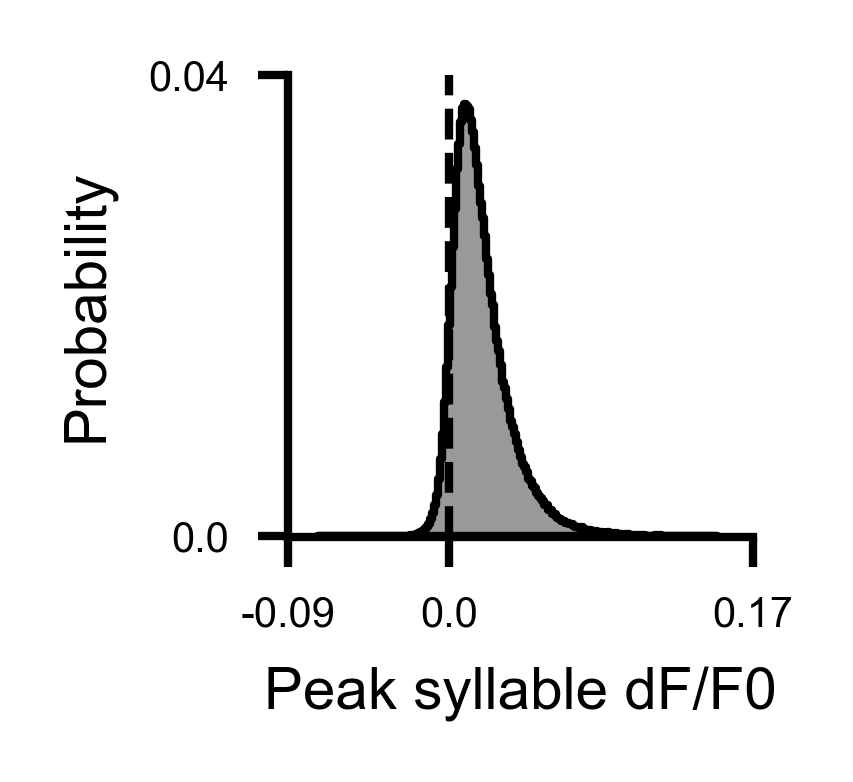

In [8]:
fig = fg(1, 1)
fig.dpi = 300
ax = sns.histplot(
    agg_df["max"],
    color="k",
    element="step",
    fill=True,
    bins=200,
    stat="probability",
    alpha=0.4,
    lw=1,
)
ax.set(xlabel="Peak syllable dF/F0")
clean_ticks(ax, "x", zero_symmetry=False, precision=2)
clean_ticks(ax, "y", zero_symmetry=False, precision=2)
ax.axvline(0, lw=1, c="k", ls="--")
sns.despine()
saver(fig, "raw-peak-syllable-dff-distribution");

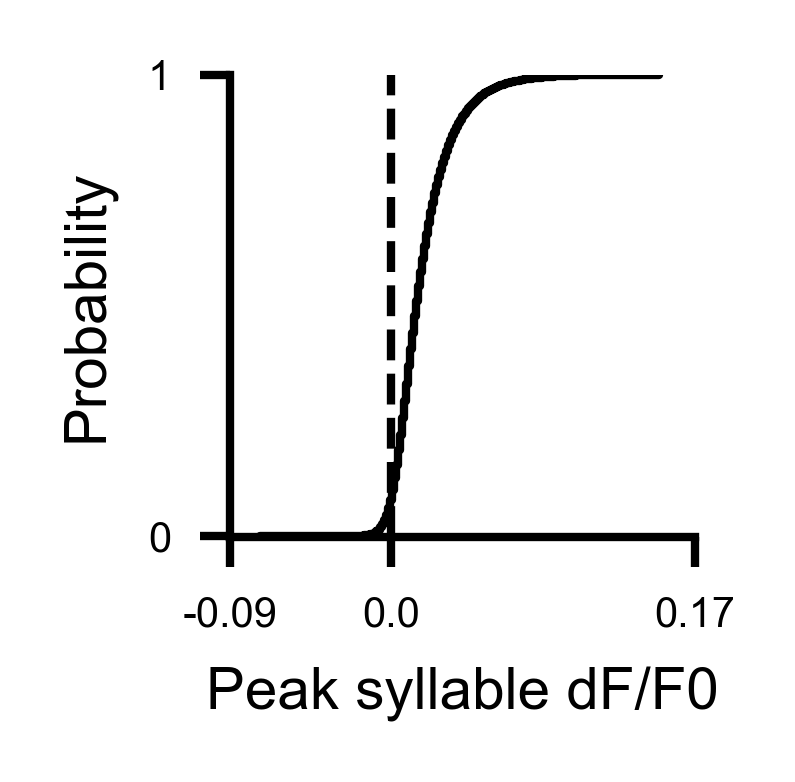

In [9]:
fig = fg(1, 1)
fig.dpi = 300
ax = sns.histplot(
    agg_df["max"],
    color="k",
    element="step",
    fill=False,
    bins=200,
    stat="probability",
    cumulative=True,
)
ax.set(xlabel="Peak syllable dF/F0", ylim=(0, 1))
clean_ticks(ax, "x", zero_symmetry=False, precision=2)
clean_ticks(ax, "y", zero_symmetry=False, dtype=int)
ax.axvline(0, lw=1, c="k", ls="--")
sns.despine()
saver(fig, "raw-peak-syllable-dff-cumulative-distribution");

In [10]:
tmp_feat_df = feat_df[feat_df['signal_dff_z_max'] < 7]

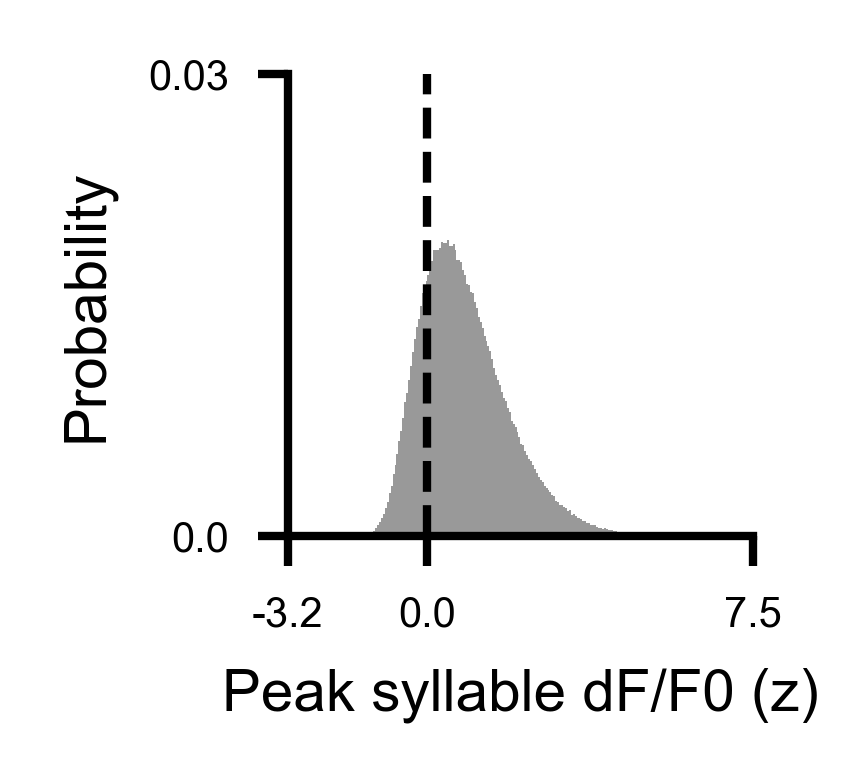

In [13]:
fig = fg(1, 1)
fig.dpi = 300
ax = sns.histplot(
    tmp_feat_df["signal_dff_z_max"],
    color="k",
    element="step",
    fill=True,
    bins=200,
    stat="probability",
    alpha=0.4,
    lw=0,
)
ax.set(xlabel="Peak syllable dF/F0 (z)", xlim=(-3.2, 7.5))
clean_ticks(ax, "x", zero_symmetry=False, precision=1)
clean_ticks(ax, "y", zero_symmetry=False, precision=2)
ax.axvline(0, lw=1, c="k", ls="--")
sns.despine()
saver(fig, "z-scored-peak-syllable-dff-distribution");

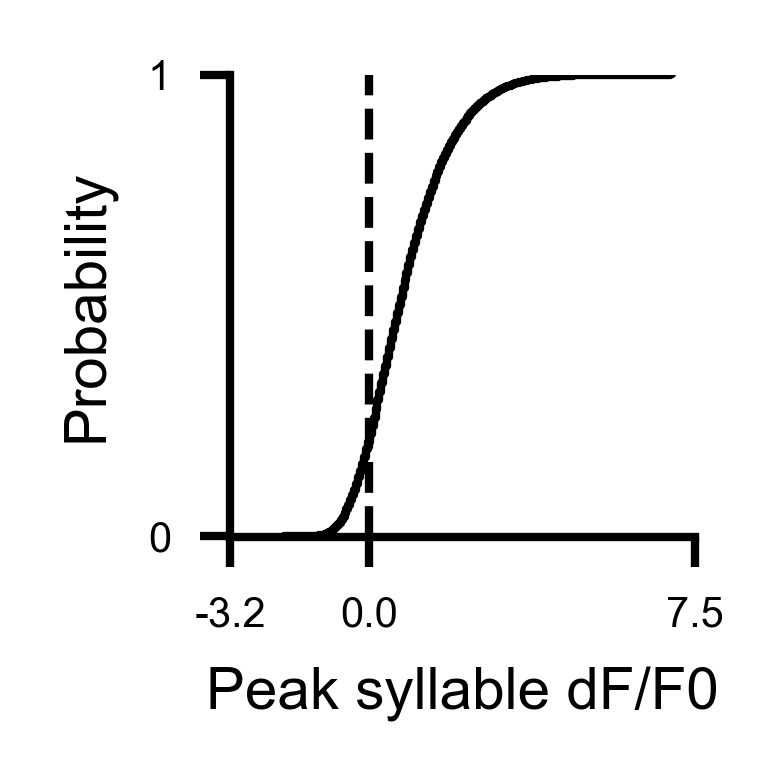

In [14]:
fig = fg(1, 1)
fig.dpi = 300
ax = sns.histplot(
    tmp_feat_df["signal_dff_z_max"],
    color="k",
    element="step",
    fill=False,
    bins=200,
    stat="probability",
    cumulative=True,
)
ax.set(xlabel="Peak syllable dF/F0", ylim=(0, 1), xlim=(-3.2, 7.5))
clean_ticks(ax, "x", zero_symmetry=False, precision=1)
clean_ticks(ax, "y", zero_symmetry=False, dtype=int)
ax.axvline(0, lw=1, c="k", ls="--")
sns.despine()
saver(fig, "z-scored-peak-syllable-dff-cumulative-distribution");